# Salary Data Classification Models

**Authors:** Franko Ndou

# Overview

The HR department plays a crucial role in identifying the right candidates for job positions. However, the process of determining a candidate's suitability can be time-consuming and subject to biases. To streamline their decision-making process and make it more data-driven, the HR department aims to develop a Machine Learning (ML) classification model. This model will predict whether a candidate is likely to earn more than $50,000 annually, helping the HR team make informed decisions about candidate qualifications.

# Dataset

I got my dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). It is salary cenus data from 1994, The target varible within the dataset is "income" which tells us if an individual makes Above $50,000 a year (1), or if they make less than or equal to that number (0).

# Importing packages and intializing data

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.io import arff
import importnb
with importnb.Notebook():
    import src.HyperParameterTuning as hpt
import warnings


warnings.filterwarnings('ignore')

/Users/ndou/anaconda3/envs/learn-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Initializing DataFrame
df = pd.read_csv("../data/SalaryData.csv")
df

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,0
1,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,0
2,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,0
3,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,1,0,0,40,0
4,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...
27498,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,1,0,0,38,0
27499,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,0,0,0,40,1
27500,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,1,0,0,40,0
27501,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,0,0,0,20,0


In [3]:
# Checking column data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27503 entries, 0 to 27502
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27503 non-null  int64 
 1   workclass       27503 non-null  object
 2   education       27503 non-null  object
 3   marital-status  27503 non-null  object
 4   occupation      27503 non-null  object
 5   relationship    27503 non-null  object
 6   race            27503 non-null  object
 7   sex             27503 non-null  int64 
 8   capital-gain    27503 non-null  int64 
 9   capital-loss    27503 non-null  int64 
 10  hours-per-week  27503 non-null  int64 
 11  income          27503 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ MB


# Spliting the dataset

To be able to create models and predictions with our data we need to split it into a train and test dataset. This will allow us to have a dataset that we can train and tune then test it on unseen data

In [4]:
# Creating test split
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing 

We usually perform these next steps after splitting to prevent data leakage, it also allows us to begin hyper paramater tuning our model so that it can fit generalized data sets

In [5]:
# Define numerical and categorical columns
numerical_columns = ['age', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race']

# Define a custom order for the 'education' column
custom_order = [
    ' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th',
    ' 10th', ' 11th', ' 12th', ' HS-grad', ' Some-college',
    ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Masters',
    ' Prof-school', ' Doctorate'
]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numerical columns
        ('cat', Pipeline([
            ('ord', OrdinalEncoder(categories=[custom_order])),  # Encode 'education' column with custom order
            ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore', categories='auto'))
        ]), ['education']),  # Encode 'education' column with custom order
        ('cat_oh', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), categorical_columns)  # Encode other categorical columns
    ])

# Fit the preprocessing step on the training data
preprocessor.fit(X_train)

# Transform the training and test data using the preprocessing step
X_train_pp = preprocessor.transform(X_train)
X_test_pp = preprocessor.transform(X_test)

# Define my pipeline with preprocessing and the Logistic Regression model
pipeline = Pipeline([
    ('model', LogisticRegression())
])

# Fit the pipeline on the preprocessed training data
pipeline.fit(X_train_pp, y_train)

# Make predictions on the preprocessed test data
y_pred = pipeline.predict(X_test_pp)

After encoding all the columns properly, making sure to use ordinal encoder for the education column as the order is likely significant to the models predictive cabailities. We can begin to balance and then predict with our dataset

# Balancing the dataset

Our dataset is incredibly imbalanced, so were going to need to oversample it and add synthetic data so that we can remove any bias

In [6]:
# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pp, y_train)

# Train the machine learning model on the balanced training data (e.g., Logistic Regression)
model = LogisticRegression()
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [7]:
y_train.value_counts(normalize = True)

income
0    0.745377
1    0.254623
Name: proportion, dtype: float64

In [8]:
y_train_balanced.value_counts(normalize = True)

income
1    0.5
0    0.5
Name: proportion, dtype: float64

We've added synthetic data to fix the balance of the dataset so that we can reliably trust our evaluation metrics. Now we can begin to actually predict with our model and hyper-parameter tune.

# Bassline Logistic Regression

The defintion of a "good" model varries completely. Based on the metrics we chose and the baseline model. We are going to be relying on accuracy and precision as our metrics of evaluation, as we want to reduce as many false positives as possible. If someone makes over $50k a year, they likely wont take the offer. So to save HR time and resources, we want to make sure that we dont turn anyone down who may actually accept the offer.

In [9]:
baseline_model = LogisticRegression(random_state=42)
basel_mod_reg = baseline_model.fit(X_train_balanced, y_train_balanced)
y_hat_train = baseline_model.predict(X_train_balanced)
y_hat_test = baseline_model.predict(X_test_pp)

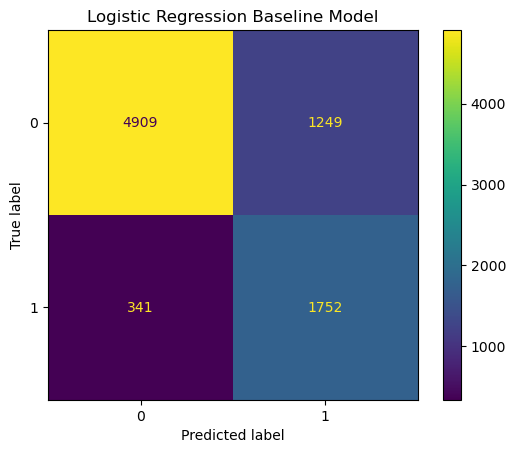

In [10]:
ConfusionMatrixDisplay.from_estimator(basel_mod_reg, X_test_pp, y_test)
plt.title('Logistic Regression Baseline Model');

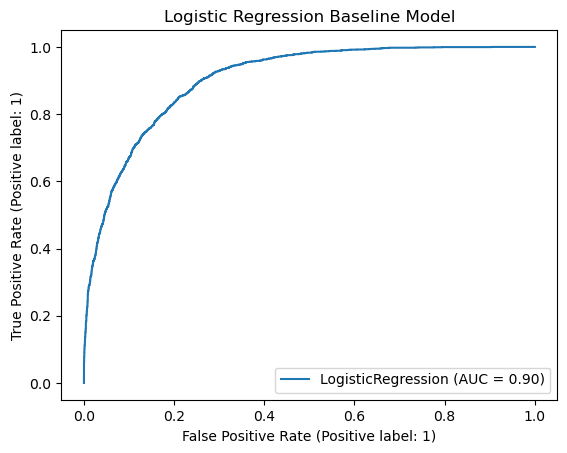

In [11]:
RocCurveDisplay.from_estimator(basel_mod_reg, X_test_pp, y_test)
plt.title("Logistic Regression Baseline Model");

In [12]:
# Results of our tests
print(F"""
Results for the Logistic Regression Baseline Model:

Accuracy train Data: {round(accuracy_score(y_train_balanced, y_hat_train) * 100, 2)}%
Accuracy test Data: {round(accuracy_score(y_test, y_hat_test) * 100, 2)}%

Recall train Data: {round(recall_score(y_train_balanced, y_hat_train) * 100, 2)}%
Recall test Data: {round(recall_score(y_test, y_hat_test) * 100, 2)}%

Precision train Data: {round(precision_score(y_train_balanced, y_hat_train) * 100, 2)}%
Precision test Data: {round(precision_score(y_test, y_hat_test) * 100, 2)}%

F1 train Data: {round(f1_score(y_train_balanced, y_hat_train) * 100, 2)}%
F1 test Data: {round(f1_score(y_test, y_hat_test) * 100, 2)}%
""")


Results for the Logistic Regression Baseline Model:

Accuracy train Data: 82.82%
Accuracy test Data: 80.73%

Recall train Data: 85.93%
Recall test Data: 83.71%

Precision train Data: 80.9%
Precision test Data: 58.38%

F1 train Data: 83.34%
F1 test Data: 68.79%



Our accurarcy is pretty good, its not extremely far off the train dataset however it can definitely be improved. Our goal is to raise the accuracy above the baseline model through hyper-parameter tuning 

Our precision is very bad though. Clearly some fitting needs to be done and our model is susceptible to false positives

The AUC curve is already good so if we can raise it even more that would be great

# Baseline Decision Tree

Decision Trees are extremely susceptible to overfitting, so we know for sure were going to have to tune this quite a bit and make sure that our model can actually be generalized. Its likely the model will go "too deep" and cause issues for our test set.

In [13]:
# Instantiating the decision tree
tree_baseline = DecisionTreeClassifier(random_state=42)
#Fitting and getting scores for both train and test
tree_baseline.fit(X_train_balanced, y_train_balanced)
dt_train_score = tree_baseline.score(X_train_balanced, y_train_balanced)
dt_test_score = tree_baseline.score(X_test_pp, y_test)
y_hat_dt_train = tree_baseline.predict(X_train_balanced)
y_hat_dt_test  = tree_baseline.predict(X_test_pp)

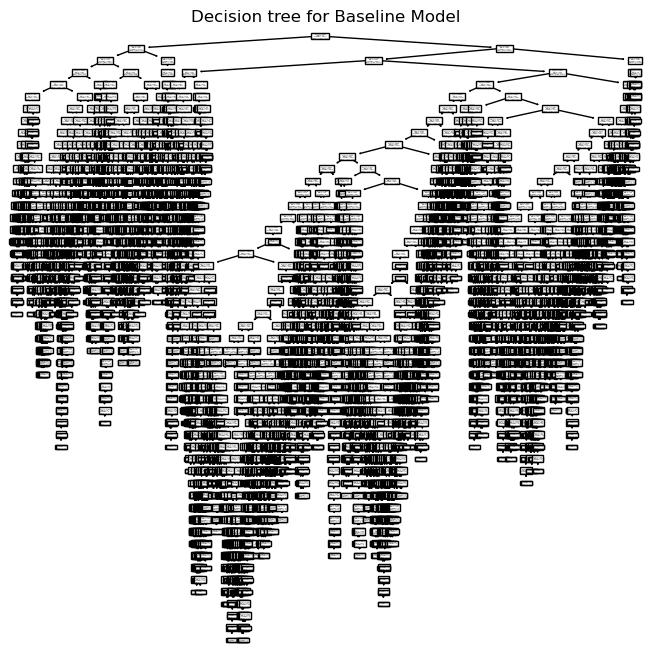

In [14]:
f, ax = plt.subplots(figsize=(8, 8))
plot_tree(tree_baseline, ax=ax)
plt.title('Decision tree for Baseline Model');

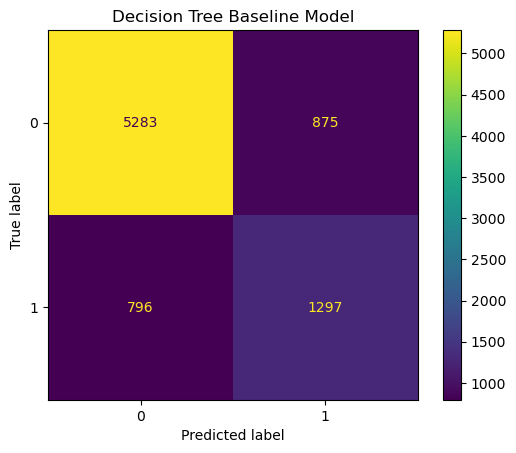

In [15]:
ConfusionMatrixDisplay.from_estimator(tree_baseline.fit(X_train_balanced, y_train_balanced), X_test_pp, y_test)
plt.title('Decision Tree Baseline Model');

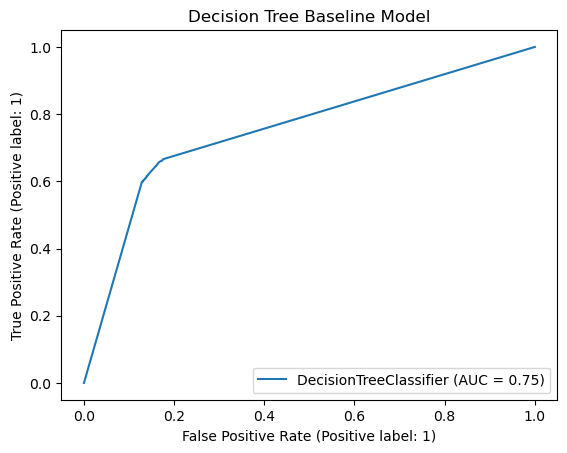

In [16]:
RocCurveDisplay.from_estimator(tree_baseline.fit(X_train_balanced, y_train_balanced), X_test_pp, y_test)
plt.title("Decision Tree Baseline Model");

In [14]:
print(F"""
Results for the Decision Tree Baseline Model:

Accuracy train Data: {round(accuracy_score(y_train_balanced, y_hat_dt_train) * 100, 2)}%
Accuracy test Data: {round(accuracy_score(y_test, y_hat_dt_test) * 100, 2)}%

Recall train Data: {round(recall_score(y_train_balanced, y_hat_dt_train) * 100, 2)}%
Recall test Data: {round(recall_score(y_test, y_hat_dt_test) * 100, 2)}%

Precision train Data: {round(precision_score(y_train_balanced, y_hat_dt_train) * 100, 2)}%
Precision test Data: {round(precision_score(y_test, y_hat_dt_test) * 100, 2)}%

F1 train Data: {round(f1_score(y_train_balanced, y_hat_dt_train) * 100, 2)}%
F1 test Data: {round(f1_score(y_test, y_hat_dt_test) * 100, 2)}%
""")



Results for the Decision Tree Baseline Model:

Accuracy train Data: 98.38%
Accuracy test Data: 79.75%

Recall train Data: 97.69%
Recall test Data: 61.97%

Precision train Data: 99.05%
Precision test Data: 59.71%

F1 train Data: 98.37%
F1 test Data: 60.82%



As expected the decision tree model is performing much worse compared to the logisitc regression out of the box. However this is to be expected and shouldnt alarm us. These scores clearly show us that the model is extremely overfitted and needs to be toned down. However its possible after all regulations, tuning, and cross-validations, the model will outperform logistic regressions. We have to experiment

# Finding the best performing model

In [ ]:
#Instantiating our ModelValidator class
validator = hpt.ModelValidator(X_train_balanced, y_train_balanced,X_test_pp,y_test)

#Calling the decision tree and logistic regression checking functions including the cross validation.

validator.check_desc_tree(cv_now=True)
validator.check_log_reg(cv_now=True)

In [ ]:
# Observing the best hyperparameters for logistic regression

validator.top_hp_lr

In [ ]:
#Observing the best hyperparameters for decision trees

validator.top_hp_dt

In [ ]:
#Looking at different scores,
validator.scores(both_models=True)